In [1]:
%matplotlib inline


from os.path import join as pjoin, exists

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from stndata import ONEMINUTESTNDTYPE, ONEMINUTESTNNAMES


In [2]:
BASEDIR = r"X:\georisk\HaRIA_B_Wind\data\derived\obs\1-minute\events-60"
OUTPUTPATH = pjoin(BASEDIR, "results")
stormdf = pd.read_pickle(pjoin(OUTPUTPATH, "stormclass.pkl"))
allstnfile = r"X:\georisk\HaRIA_B_Wind\data\raw\from_bom\2022\1-minute\HD01D_StationDetails.txt"
allstndf = pd.read_csv(allstnfile, sep=',', index_col='stnNum',
                       names=ONEMINUTESTNNAMES,
                       keep_default_na=False,
                       converters={
                            'stnName': str.strip,
                            'stnState': str.strip,
                            'stnDataStartYear': lambda s: int(float(s.strip() or 0)),
                            'stnDataEndYear': lambda s: int(float(s.strip() or 0))
                        })

In [3]:
def loadDailyMaxData(stnNum: int) -> pd.DataFrame:
    """
    Load daily maximum wind gust data for a given station

    :param stnNum: Station identification number
    :type stnNum: int
    :return: `pd.DataFrame` containing daily maximum wind gust data for the station, along with other variables associated with the gust event.
    :rtype: pd.DataFrame
    """
    try:
        df = pd.read_pickle(pjoin(BASEDIR, 'dailymax', f"{stnNum:06d}.pkl"))
    except FileNotFoundError:
        print(f"No data for station {stnNum}")
    df = df.reset_index(drop=False).set_index(['stnNum', 'date'])
    return df

In [4]:
alldflist = []
for stn in allstndf.index:
    if exists(pjoin(BASEDIR, 'dailymax', f"{stn:06d}.pkl")):
        df = loadDailyMaxData(stn)
        alldflist.append(df)
    else:
        print(f"No data for station {stn}")
    
alldf = pd.concat(alldflist)
alldf.reset_index(drop=False, inplace=True)
alldf['date'] = pd.to_datetime(alldf.date)
alldf.set_index(['stnNum', 'date'], inplace=True)

No data for station 87185
No data for station 66198
No data for station 66199
No data for station 66200
No data for station 66201
No data for station 66202
No data for station 66203
No data for station 60168


In [5]:
datadf = stormdf.join(alldf, on=['stnNum', 'date'], how='inner')

Storms with a gust wind speed over 150 km/h and a gust ratio > 9.0 (about the 98th percentile of gust ratio values) are considered spurious and reclassified as "Unclassified".

In [7]:
datadf.loc[(datadf.windgust>150) & (datadf.gustratio > 9.0) & (~datadf.stormType.isin(['Spike', 'Unclassified'])), 'stormType'] = 'Unclassified'

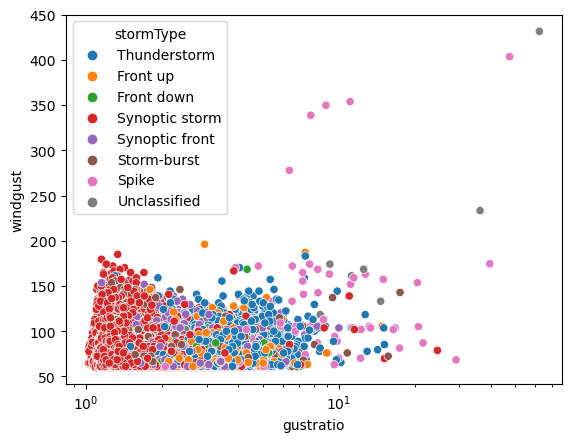

In [8]:
ax=sns.scatterplot(data=datadf, x='gustratio', y='windgust', hue='stormType',
                   hue_order=['Thunderstorm', 'Front up', 'Front down', 
                       'Synoptic storm', 'Synoptic front', 'Storm-burst', 'Spike', 'Unclassified'])
ax.set_xscale('log')

In [9]:
tsGust = datadf.loc[datadf.stormType.isin(['Thunderstorm', 'Front up', 'Front down'])]
synGust = datadf.loc[datadf.stormType.isin(['Synoptic storm', 'Synoptic front', 'Storm-burst'])]

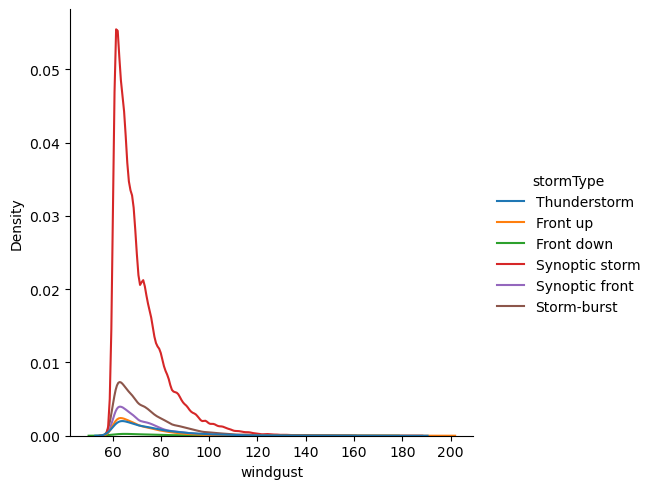

In [9]:
sns.displot(data=datadf.loc[~datadf.stormType.isin(['Spike', 'Unclassified'])],
            x='windgust', hue='stormType', kind='kde',
            hue_order=['Thunderstorm', 'Front up', 'Front down', 
                       'Synoptic storm', 'Synoptic front', 'Storm-burst'])